In [58]:
# generating data
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)

from torch import nn
import torch
from optimisation.gen_data import getTicksForDay
from torch.utils.data import DataLoader, TensorDataset
from torch import optim


tick_data = []
for i in range(10000):
    _, ticks = getTicksForDay(i)
    # tick_data.extend([[tick.day, tick.tick, tick.sell_price] for tick in tmp])
    tick_data.extend(ticks)

In [59]:
# x[1], 
def create_dataset(dataset: list, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        # target = dataset[i + lookback][2]
        X.append([[x.sell_price] for x in dataset[i:i+lookback]])
        y.append(dataset[i + lookback].sell_price)
    return torch.FloatTensor(X), torch.FloatTensor(y)

TRAIN_SIZE = 9000
train = tick_data[:TRAIN_SIZE]
test = tick_data[TRAIN_SIZE:]
lookback = 5

x_train, y_train = create_dataset(train, lookback)
x_test, y_test = create_dataset(test, lookback)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        last_time_step = x[:, -1, :]
        out = self.linear(last_time_step)
        return out

Epoch [10/1000], Loss: 374.9076
Epoch [20/1000], Loss: 973.1245
Epoch [30/1000], Loss: 954.6011
Epoch [40/1000], Loss: 6780.5806
Epoch [50/1000], Loss: 5780.3052
Epoch [60/1000], Loss: 1914.1742
Epoch [70/1000], Loss: 2241.4001
Epoch [80/1000], Loss: 2487.5549
Epoch [90/1000], Loss: 4462.2222
Epoch [100/1000], Loss: 4799.7231
Epoch [110/1000], Loss: 1753.7710
Epoch [120/1000], Loss: 165.0877
Epoch [130/1000], Loss: 1596.1134
Epoch [140/1000], Loss: 2545.7939
Epoch [150/1000], Loss: 2731.8040
Epoch [160/1000], Loss: 2469.9978
Epoch [170/1000], Loss: 123.7928
Epoch [180/1000], Loss: 435.6826
Epoch [190/1000], Loss: 1451.4706
Epoch [200/1000], Loss: 503.2814
Epoch [210/1000], Loss: 3362.9402
Epoch [220/1000], Loss: 198.2006
Epoch [230/1000], Loss: 562.4534
Epoch [240/1000], Loss: 712.0456
Epoch [250/1000], Loss: 1996.8926
Epoch [260/1000], Loss: 568.2557
Epoch [270/1000], Loss: 205.2407
Epoch [280/1000], Loss: 2148.0969
Epoch [290/1000], Loss: 804.8757
Epoch [300/1000], Loss: 352.3316
Epo

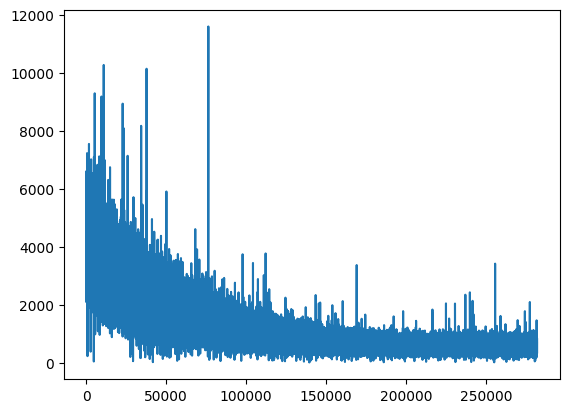

In [60]:

from matplotlib import pyplot as plt


input_size = x_train.shape[2]
model = LSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(targets.unsqueeze(1)[:5])
        # print(outputs[:5])
        loss = criterion(outputs, targets.unsqueeze(1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(losses)
# # Evaluation
# model.eval()
# with torch.no_grad():
#     total_loss = 0
#     for inputs, targets in test_loader:
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         total_loss += loss.item()

#     print(f'Test Loss: {total_loss / len(test_loader):.4f}')

In [71]:
torch.save(model.state_dict(), 'model.pth')

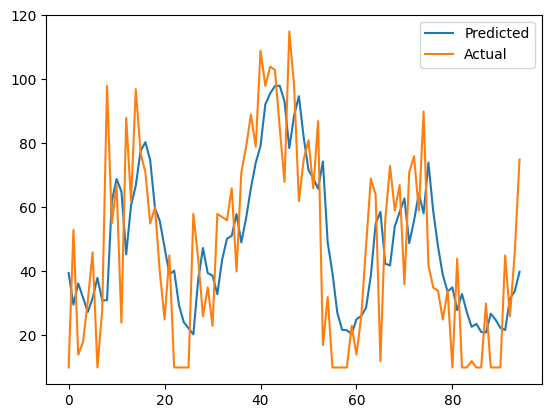

In [66]:
# Create a dataset for the single day
vals = 100
x_test, y_test = create_dataset(test[:vals], lookback)

# # Predict using the model
with torch.no_grad():
    y_test_pred = model(x_test).squeeze().numpy()

import matplotlib.pyplot as plt

from optimisation.utils import get_ema

plt.plot(y_test_pred[:vals], label='Predicted')
plt.plot(y_test[:vals], label='Actual')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np



lookback = 1
x, y = create_dataset(y_train_ds, lookback=lookback)

model = LSTMModel()
optimisation = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x, y), shuffle=True, batch_size=8)

epochs = 1000

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimisation.zero_grad()
        loss.backward()
        optimisation.step()

    print(f"epoch: {epoch}")
    if epoch % 100 != 0:
        continue